In [4]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pwd: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [6]:
# Cambiamos de directorio al Drive
import os
os.chdir("/content/drive/MyDrive/Hackaton2021/codigo/pruebas/")
!ls

 Analisis_texto			     res.png
 archive.zip			     resultado_text_detection2.png
 CalidadDeLaImagen.ipynb	     resultado_text_detection.png
'Copia de Pre-procesamiento.ipynb'   Segmentation.ipynb
 deep-text-recognition-benchmark     seg_Text_Recognition2.ipynb
 Download_Github.ipynb		     seg_Text_Recognition3.ipynb
 eng.traineddata		     seg_Text_Recognition4.ipynb
 Face_recognition_prueba1.ipynb      seg_Text_Recognition5.ipynb
 Face_recognition_tutorial.ipynb     seg_Text_Recognition.ipynb
 find_contours.py		     Super-resolution1.ipynb
 images				     test0.png
 images_texto			     test1.png
 model				     test.png
 OCR-tf2			     Text_detection_prueba1.ipynb
 OpenCV-Document-Scanner-master      Text_detection_prueba2.ipynb
 oxford_segmentation.h5		     Text_detection_prueba3.ipynb
 Pre-procesamiento.ipynb	     Text_recognition_prueba1.ipynb
 __pycache__			     Text_recognition_prueba2.ipynb
 recortes			     unet
 recortes2			     WebScrapping.ipynb


In [7]:
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np

## Load images

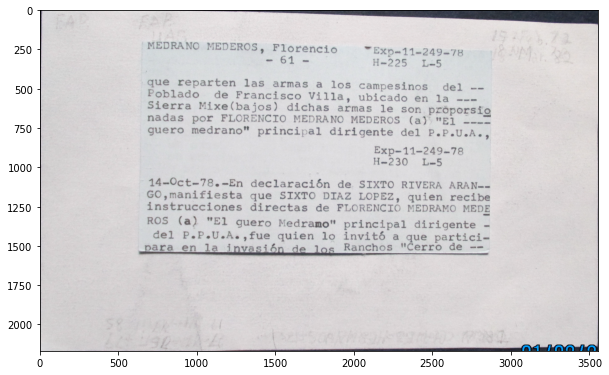

In [9]:
image_name = 'images/00092.png'
image_test = cv2.imread(image_name, 1)
rows, cols, ch = image_test.shape
flat_img = image_test.reshape((-1, 1))

plt.figure(figsize=(10,10))
plt.imshow(image_test, cmap='gray')
plt.show()

## U-NET

#### Load data

In [10]:
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import cv2
from glob import glob

In [11]:
input_dir = "unet/images/"
target_dir = "unet/target/"
img_size = image_test.shape
num_classes = 2
batch_size = 32

## Generator

In [12]:
class Patches(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = cv2.imread(path, cv2.IMREAD_COLOR) / 255.
            img = cv2.blur(img, (5, 5))
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            y[j] = np.expand_dims(img, 2)
        return x, y

### Architecture

In [13]:
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size)
  
  ### [First half of the network: downsampling inputs] ###
  
  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  
  previous_block_activation = x  # Set aside residual
  
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    # Project residual
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
  ### [Second half of the network: upsampling inputs] ###
  for filters in [256, 128, 64, 32]:
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)
    
    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual
  
  # Add a per-pixel classification layer
  outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
  
  # Define the model
  model = keras.Model(inputs, outputs)
  return model

In [14]:
# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

# Build model
model = get_model(img_size, 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2169, 3553,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1085, 1777, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1085, 1777, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1085, 1777, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Test

In [15]:
model.load_weights('oxford_segmentation.h5')

In [16]:
res = model.predict(np.expand_dims(image_test/255., 0))

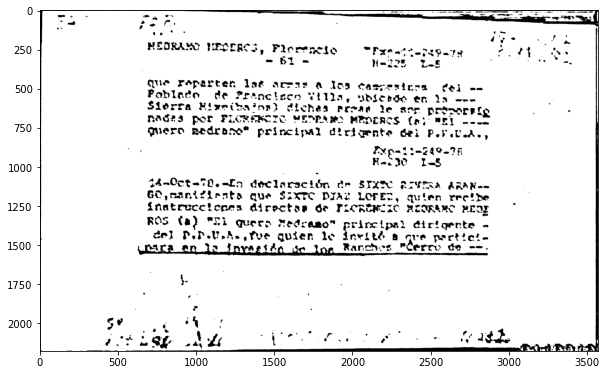

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(res[0, ..., 0] > 0.95, cmap='gray')
plt.show()